In [47]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import skfuzzy.control as ctrl
import seaborn as sns

In [48]:
books = pd.read_csv('C:\\Users\\Velisia Nihan\\Downloads\\books.csv')
ratings = pd.read_csv('C:\\Users\\Velisia Nihan\\Downloads\\ratings.csv')

books_selected = books[['book_id', 'title', 'authors', 'average_rating', 'ratings_count', 'ratings_5']]

merged = pd.merge(ratings, books_selected, on='book_id')

merged = merged[['user_id', 'book_id', 'rating', 'title', 'authors', 'average_rating', 'ratings_count', 'ratings_5']]
merged.columns = ['User', 'BookID', 'Rating', 'Title', 'Author', 'AvgRating', 'RatingCount', 'Rating5Star']

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(merged.head())

   User  BookID  Rating                                                      Title                       Author  AvgRating  RatingCount  Rating5Star
0   314       1       5  Harry Potter and the Half-Blood Prince (Harry Potter, #6)  J.K. Rowling, Mary GrandPré       4.54      1678823      1161491
1   439       1       3  Harry Potter and the Half-Blood Prince (Harry Potter, #6)  J.K. Rowling, Mary GrandPré       4.54      1678823      1161491
2   588       1       5  Harry Potter and the Half-Blood Prince (Harry Potter, #6)  J.K. Rowling, Mary GrandPré       4.54      1678823      1161491
3  1169       1       4  Harry Potter and the Half-Blood Prince (Harry Potter, #6)  J.K. Rowling, Mary GrandPré       4.54      1678823      1161491
4  1185       1       4  Harry Potter and the Half-Blood Prince (Harry Potter, #6)  J.K. Rowling, Mary GrandPré       4.54      1678823      1161491


In [113]:
# Normalisasi ratings_count dan ratings_5 ke skala 0–100

max_rating = books["ratings_count"].max()
books["ratings_count_norm"] = (books["ratings_count"] / max_rating * 100).round(0)
books["ratings_5_norm"] = (books["ratings_5"] / max_rating * 100).round(0)


def fuzzify_rating(r):
    if r >= 4.2:
        return "tinggi"
    elif r >= 3.5:
        return "sedang"
    else:
        return "rendah"

def fuzzify_count(c):
    if c >= 66:
        return "banyak"
    elif c >= 33:
        return "sedang"
    else:
        return "sedikit"

def fuzzy_recommendation(row):
    rating = fuzzify_rating(row["average_rating"])
    count = fuzzify_count(row["ratings_count_norm"])
    rating5 = fuzzify_count(row["ratings_5_norm"])

    if rating == "tinggi" and count == "banyak" or rating5 == "banyak":
        return "Sangat Direkomendasikan"
    elif rating == "tinggi" and count == "sedang":
        return "Direkomendasikan"
    elif rating == "sedang" and rating5 == "banyak":
        return "Mungkin Direkomendasikan"
    else:
        return "Tidak Direkomendasikan"


# Tambahkan kolom rekomendasi
books["Rekomendasi"] = books.apply(fuzzy_recommendation, axis=1)

# Tampilkan hasil dengan kolom normalisasi
books[["title", "average_rating", "ratings_count_norm", "ratings_5_norm", "Rekomendasi"]].head(10)



,title,average_rating,ratings_count_norm,ratings_5_norm,Rekomendasi
0,"The Hunger Games (The Hunger Games, #1)",4.34,100.0,57.0,Sangat Direkomendasikan
1,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4.44,96.0,63.0,Sangat Direkomendasikan
2,"Twilight (Twilight, #1)",3.57,81.0,28.0,Tidak Direkomendasikan
3,To Kill a Mockingbird,4.25,67.0,36.0,Sangat Direkomendasikan
4,The Great Gatsby,3.89,56.0,20.0,Tidak Direkomendasikan
5,The Fault in Our Stars,4.26,49.0,27.0,Direkomendasikan
6,The Hobbit,4.25,43.0,23.0,Direkomendasikan
7,The Catcher in the Rye,3.79,43.0,15.0,Tidak Direkomendasikan
8,"Angels & Demons (Robert Langdon, #1)",3.85,42.0,14.0,Tidak Direkomendasikan
9,Pride and Prejudice,4.24,43.0,24.0,Direkomendasikan


C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


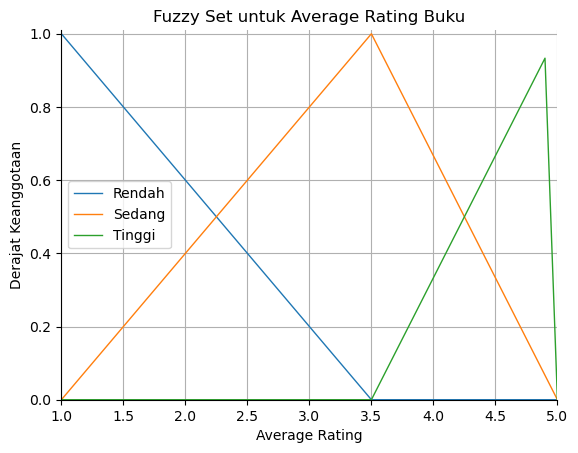

Tabel Interpretasi Fungsi Keanggotaan Fuzzy untuk Average Rating:


,Label,Range,Arti Fuzzy
0,Rendah,"[1.0, 1.0, 3.5]","Mulai dari 1.0 (penuh), turun ke 0 di 3.5"
1,Sedang,"[1.0, 3.5, 5.0]","Mulai naik dari 1.0, puncak di 3.5, turun ke 0 di 5.0"
2,Tinggi,"[3.5, 5.0, 5.0]","Mulai dari 3.5, puncak di 5.0, tetap tinggi"


In [114]:
#AVERAGE RATING

# Definisikan universe untuk rating
rating = ctrl.Antecedent(np.arange(1.0, 5.1, 0.1), 'rating')

# Fungsi keanggotaan fuzzy (segitiga)
rating['Rendah'] = fuzz.trimf(rating.universe, [1.0, 1.0, 3.5])
rating['Sedang'] = fuzz.trimf(rating.universe, [1.0, 3.5, 5.0])
rating['Tinggi'] = fuzz.trimf(rating.universe, [3.5, 5.0, 5.0])

# Visualisasi fuzzy set
rating.view()
plt.title('Fuzzy Set untuk Average Rating Buku')
plt.xlabel('Average Rating')
plt.ylabel('Derajat Keanggotaan')
plt.grid(True)
plt.legend(['Rendah', 'Sedang', 'Tinggi'])
plt.show()

# Buat DataFrame untuk tabel fuzzy
data = {
    'Label': ['Rendah', 'Sedang', 'Tinggi'],
    'Range': ['[1.0, 1.0, 3.5]', '[1.0, 3.5, 5.0]', '[3.5, 5.0, 5.0]'],
    'Arti Fuzzy': [
        'Mulai dari 1.0 (penuh), turun ke 0 di 3.5',
        'Mulai naik dari 1.0, puncak di 3.5, turun ke 0 di 5.0',
        'Mulai dari 3.5, puncak di 5.0, tetap tinggi'
    ]
}

df = pd.DataFrame(data)

# Tampilkan tabel rapi
print("Tabel Interpretasi Fungsi Keanggotaan Fuzzy untuk Average Rating:")
display(df)



C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


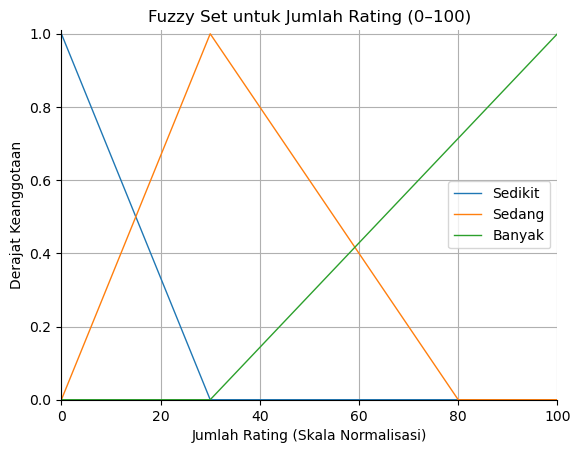

Tabel Interpretasi Fuzzy untuk Jumlah Rating (0–100):


,Label,Range,Arti Fuzzy
0,Sedikit,"[0, 0, 30]","Jumlah rating rendah, penuh keanggotaan di 0, menurun ke 0 di 30"
1,Sedang,"[0, 30, 80]","Keanggotaan mulai naik dari 0, puncak di 30, turun ke 0 di 80"
2,Banyak,"[30, 100, 100]","Keanggotaan mulai dari 30, penuh keanggotaan dari 100 ke atas"


In [115]:
# RATING COUNT NORMALIZED (0–100)
ratings_count_norm = ctrl.Antecedent(np.arange(0, 101, 1), 'ratings_count_norm')

# Fungsi keanggotaan fuzzy
ratings_count_norm['Sedikit'] = fuzz.trimf(ratings_count_norm.universe, [0, 0, 30])
ratings_count_norm['Sedang'] = fuzz.trimf(ratings_count_norm.universe, [0, 30, 80])
ratings_count_norm['Banyak'] = fuzz.trimf(ratings_count_norm.universe, [30, 100, 100])

# Visualisasi fuzzy set
ratings_count_norm.view()
plt.title('Fuzzy Set untuk Jumlah Rating (0–100)')
plt.xlabel('Jumlah Rating (Skala Normalisasi)')
plt.ylabel('Derajat Keanggotaan')
plt.grid(True)
plt.legend(['Sedikit', 'Sedang', 'Banyak'])
plt.show()

# Buat DataFrame interpretasi
data_ratings_count_norm = {
    'Label': ['Sedikit', 'Sedang', 'Banyak'],
    'Range': ['[0, 0, 30]', '[0, 30, 80]', '[30, 100, 100]'],
    'Arti Fuzzy': [
        'Jumlah rating rendah, penuh keanggotaan di 0, menurun ke 0 di 30',
        'Keanggotaan mulai naik dari 0, puncak di 30, turun ke 0 di 80',
        'Keanggotaan mulai dari 30, penuh keanggotaan dari 100 ke atas'
    ]
}

df_ratings_count_norm = pd.DataFrame(data_ratings_count_norm)

# Tampilkan tabel
print("Tabel Interpretasi Fuzzy untuk Jumlah Rating (0–100):")
display(df_ratings_count_norm)


C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


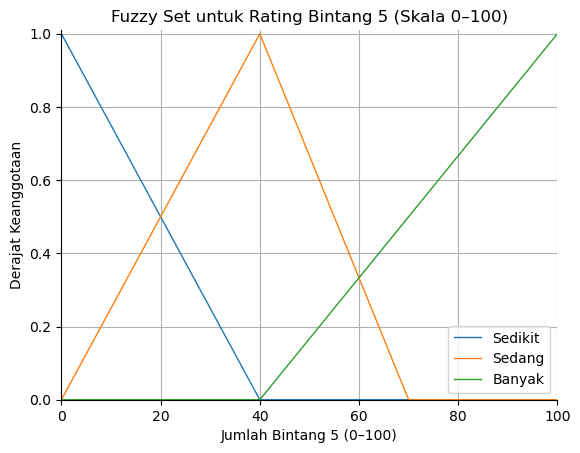

Tabel Interpretasi Fungsi Keanggotaan Fuzzy untuk Rating Bintang 5 (Skala 0–100):


,Label,Range,Arti Fuzzy
0,Sedikit,"[0, 0, 40]","Jumlah rating bintang 5 rendah, keanggotaan penuh di 0, turun ke 0 di 40"
1,Sedang,"[0, 40, 70]","Naik dari 0, puncak di 40, turun ke 0 di 70"
2,Banyak,"[40, 100, 100]","Mulai dari 40, penuh keanggotaan dari 100"


In [116]:
# RATING 5 (SKALA 0–100)
ratings_5_norm = ctrl.Antecedent(np.arange(0, 101, 1), 'ratings_5_norm')

# Fungsi keanggotaan fuzzy (segitiga) skala 0–100
ratings_5_norm['Sedikit'] = fuzz.trimf(ratings_5_norm.universe, [0, 0, 40])
ratings_5_norm['Sedang'] = fuzz.trimf(ratings_5_norm.universe, [0, 40, 70])
ratings_5_norm['Banyak'] = fuzz.trimf(ratings_5_norm.universe, [40, 100, 100])

# Visualisasi fuzzy set
ratings_5_norm.view()
plt.title('Fuzzy Set untuk Rating Bintang 5 (Skala 0–100)')
plt.xlabel('Jumlah Bintang 5 (0–100)')
plt.ylabel('Derajat Keanggotaan')
plt.grid(True)
plt.legend(['Sedikit', 'Sedang', 'Banyak'])
plt.show()

# Buat tabel fuzzy interpretasi
data_ratings_5_scaled = {
    'Label': ['Sedikit', 'Sedang', 'Banyak'],
    'Range': ['[0, 0, 40]', '[0, 40, 70]', '[40, 100, 100]'],
    'Arti Fuzzy': [
        'Jumlah rating bintang 5 rendah, keanggotaan penuh di 0, turun ke 0 di 40',
        'Naik dari 0, puncak di 40, turun ke 0 di 70',
        'Mulai dari 40, penuh keanggotaan dari 100'
    ]
}

df_ratings_5_scaled = pd.DataFrame(data_ratings_5_scaled)

# Tampilkan tabel
print("Tabel Interpretasi Fungsi Keanggotaan Fuzzy untuk Rating Bintang 5 (Skala 0–100):")
display(df_ratings_5_scaled)


In [117]:
rekomendasi = ctrl.Consequent(np.arange(0, 101, 1), 'rekomendasi')
rekomendasi['Tidak'] = fuzz.trimf(rekomendasi.universe, [0, 0, 50])
rekomendasi['Ya'] = fuzz.trimf(rekomendasi.universe, [50, 100, 100])

In [118]:
rule1 = ctrl.Rule(rating['Tinggi'] & ratings_count_norm['Banyak'] & ratings_5_norm['Banyak'], rekomendasi['Ya'])
rule2 = ctrl.Rule(rating['Tinggi'] & ratings_count_norm['Sedang'] & (ratings_5_norm['Sedang'] | ratings_5_norm['Banyak']), rekomendasi['Ya'])
rule3 = ctrl.Rule(rating['Tinggi'] & ratings_count_norm['Sedikit'] & ratings_5_norm['Banyak'], rekomendasi['Ya'])
rule4 = ctrl.Rule(rating['Sedang'] & ratings_count_norm['Banyak'] & (ratings_5_norm['Sedang'] | ratings_5_norm['Banyak']), rekomendasi['Ya'])
rule5 = ctrl.Rule(rating['Sedang'] & ratings_count_norm['Sedang'] & ratings_5_norm['Banyak'], rekomendasi['Ya'])
rule6 = ctrl.Rule(rating['Sedang'] & ratings_count_norm['Sedikit'], rekomendasi['Tidak'])
rule7 = ctrl.Rule(rating['Rendah'] | ratings_5_norm['Sedikit'], rekomendasi['Tidak'])
rule8 = ctrl.Rule(rating['Rendah'] & ratings_count_norm['Banyak'], rekomendasi['Tidak'])

C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Hasil fuzzy: 81.94
Rekomendasi Buku: Sangat Direkomendasikan


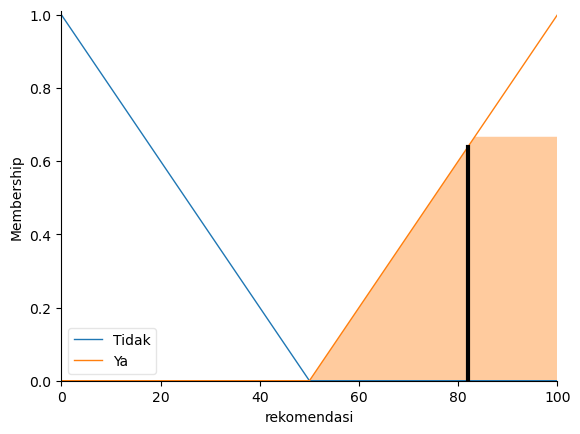

In [119]:
# === 4. Bangun dan Simulasi Sistem Fuzzy ===
rekomendasi_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
rekomendasi_sim = ctrl.ControlSystemSimulation(rekomendasi_ctrl)

# === 5. Masukkan Nilai Contoh ===
rekomendasi_sim.input['rating'] = 4.5
rekomendasi_sim.input['ratings_count_norm'] = 90
rekomendasi_sim.input['ratings_5_norm'] = 80

# === 6. Proses dan Visualisasi ===
rekomendasi_sim.compute()
rekomendasi.view(sim=rekomendasi_sim)

# === 7. Ambil Hasil Output ===
hasil = rekomendasi_sim.output['rekomendasi']

# Interpretasi hasil
if hasil >= 70:
    keputusan = "Sangat Direkomendasikan"
elif hasil >= 40:
    keputusan = "Direkomendasikan"
else:
    keputusan = "Tidak Direkomendasikan"

# Cetak hasil
print(f"Hasil fuzzy: {hasil:.2f}")
print(f"Rekomendasi Buku: {keputusan}")

C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Hasil fuzzy: 56.21
Rekomendasi Buku: Direkomendasikan


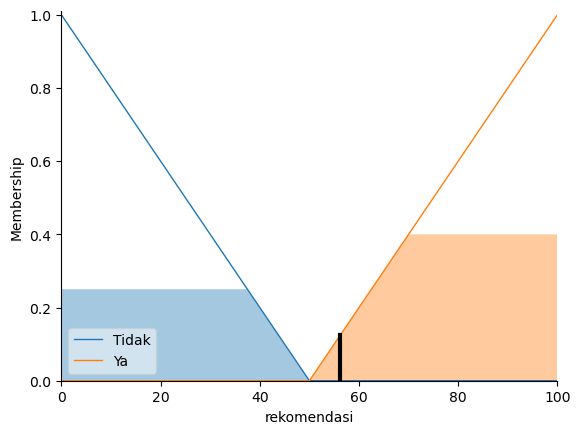

In [120]:
# === 4. Bangun dan Simulasi Sistem Fuzzy ===
rekomendasi_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
rekomendasi_sim = ctrl.ControlSystemSimulation(rekomendasi_ctrl)

# === 5. Masukkan Nilai Contoh ===
rekomendasi_sim.input['rating'] = 4.5
rekomendasi_sim.input['ratings_count_norm'] = 60
rekomendasi_sim.input['ratings_5_norm'] = 30

# === 6. Proses dan Visualisasi ===
rekomendasi_sim.compute()
rekomendasi.view(sim=rekomendasi_sim)

# === 7. Ambil Hasil Output ===
hasil = rekomendasi_sim.output['rekomendasi']

# Interpretasi hasil
if hasil >= 70:
    keputusan = "Sangat Direkomendasikan"
elif hasil >= 40:
    keputusan = "Direkomendasikan"
else:
    keputusan = "Tidak Direkomendasikan"

# Cetak hasil
print(f"Hasil fuzzy: {hasil:.2f}")
print(f"Rekomendasi Buku: {keputusan}")

C:\Users\Velisia Nihan\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Hasil fuzzy: 30.57
Rekomendasi Buku: Tidak Direkomendasikan


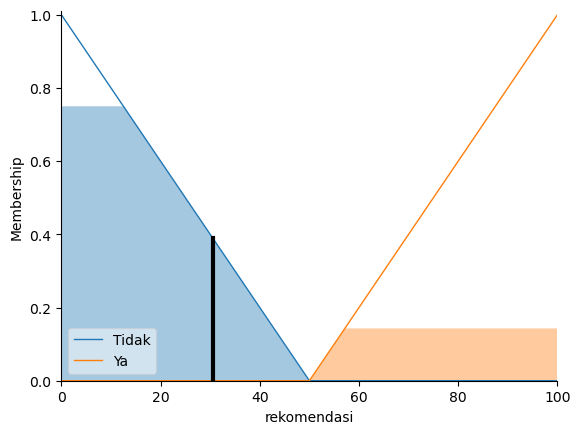

In [121]:
# === 4. Bangun dan Simulasi Sistem Fuzzy ===
rekomendasi_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
rekomendasi_sim = ctrl.ControlSystemSimulation(rekomendasi_ctrl)

# === 5. Masukkan Nilai Contoh ===
rekomendasi_sim.input['rating'] = 2.5
rekomendasi_sim.input['ratings_count_norm'] = 40
rekomendasi_sim.input['ratings_5_norm'] = 10

# === 6. Proses dan Visualisasi ===
rekomendasi_sim.compute()
rekomendasi.view(sim=rekomendasi_sim)

# === 7. Ambil Hasil Output ===
hasil = rekomendasi_sim.output['rekomendasi']

# Interpretasi hasil
if hasil >= 70:
    keputusan = "Sangat Direkomendasikan"
elif hasil >= 40:
    keputusan = "Direkomendasikan"
else:
    keputusan = "Tidak Direkomendasikan"

# Cetak hasil
print(f"Hasil fuzzy: {hasil:.2f}")
print(f"Rekomendasi Buku: {keputusan}")

In [122]:
y_true = []
y_pred = []

for index, row in books.iterrows():
    rating_val = row['average_rating']
    count_val = row['ratings_count_norm']
    rating5_val = row['ratings_5_norm']
    label = row['Label_Manual']

    rekomendasi_sim.input['rating'] = rating_val
    rekomendasi_sim.input['ratings_count_norm'] = count_val
    rekomendasi_sim.input['ratings_5_norm'] = rating5_val

    rekomendasi_sim.compute()
    result = rekomendasi_sim.output['rekomendasi']

    if hasil >= 60:
        pred = 2  # Sangat Direkomendasikan
    elif hasil >= 30:
        pred = 1  # Direkomendasikan
    else:
        pred = 0  # Tidak Direkomendasikan


    y_true.append(label)
    y_pred.append(pred)

# Evaluasi
akurasi = accuracy_score(y_true, y_pred)
print(f"Akurasi Sistem Fuzzy: {akurasi * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Akurasi Sistem Fuzzy: 59.89%

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1912
           1       0.60      1.00      0.75      5989
           2       0.00      0.00      0.00      2099

    accuracy                           0.60     10000
   macro avg       0.20      0.33      0.25     10000
weighted avg       0.36      0.60      0.45     10000



D:\DKA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\DKA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\DKA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [134]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
ratings = pd.read_csv('C:\\Users\\Velisia Nihan\\Downloads\\ratings.csv')
ratings = ratings.head(10000)  # subset kecil

# Mapping user_id dan book_id ke indeks integer
user_ids = ratings['user_id'].unique()
book_ids = ratings['book_id'].unique()

user_to_index = {user: i for i, user in enumerate(user_ids)}
book_to_index = {book: i for i, book in enumerate(book_ids)}

ratings['user_index'] = ratings['user_id'].map(user_to_index)
ratings['book_index'] = ratings['book_id'].map(book_to_index)

In [135]:
n_users = len(user_ids)
n_books = len(book_ids)
n_factors = 30  # faktor laten lebih banyak
alpha = 0.005   # learning rate lebih kecil
n_epochs = 50
reg = 0.02      # regularisasi sedikit lebih besar

# Inisialisasi matriks P dan Q
P = np.random.normal(scale=1./n_factors, size=(n_users, n_factors))
Q = np.random.normal(scale=1./n_factors, size=(n_books, n_factors))

# Training matrix factorization dengan SGD
for epoch in range(n_epochs):
    for row in ratings.itertuples():
        u = row.user_index
        i = row.book_index
        r_ui = row.rating

        pred = np.dot(P[u, :], Q[i, :].T)
        err = r_ui - pred

        P[u, :] += alpha * (err * Q[i, :] - reg * P[u, :])
        Q[i, :] += alpha * (err * P[u, :] - reg * Q[i, :])

    # Hitung MSE per epoch untuk monitoring
    preds = np.array([np.dot(P[row.user_index], Q[row.book_index].T) for row in ratings.itertuples()])
    mse = mean_squared_error(ratings['rating'], preds)
    print(f"Epoch {epoch+1}/{n_epochs}, MSE: {mse:.4f}")

Epoch 1/50, MSE: 16.1232
Epoch 2/50, MSE: 16.0494
Epoch 3/50, MSE: 15.4351
Epoch 4/50, MSE: 11.5625
Epoch 5/50, MSE: 4.7057
Epoch 6/50, MSE: 2.4502
Epoch 7/50, MSE: 1.7854
Epoch 8/50, MSE: 1.4633
Epoch 9/50, MSE: 1.2726
Epoch 10/50, MSE: 1.1471
Epoch 11/50, MSE: 1.0592
Epoch 12/50, MSE: 0.9947
Epoch 13/50, MSE: 0.9453
Epoch 14/50, MSE: 0.9060
Epoch 15/50, MSE: 0.8737
Epoch 16/50, MSE: 0.8463
Epoch 17/50, MSE: 0.8225
Epoch 18/50, MSE: 0.8012
Epoch 19/50, MSE: 0.7818
Epoch 20/50, MSE: 0.7638
Epoch 21/50, MSE: 0.7468
Epoch 22/50, MSE: 0.7305
Epoch 23/50, MSE: 0.7147
Epoch 24/50, MSE: 0.6993
Epoch 25/50, MSE: 0.6841
Epoch 26/50, MSE: 0.6691
Epoch 27/50, MSE: 0.6542
Epoch 28/50, MSE: 0.6395
Epoch 29/50, MSE: 0.6248
Epoch 30/50, MSE: 0.6104
Epoch 31/50, MSE: 0.5961
Epoch 32/50, MSE: 0.5820
Epoch 33/50, MSE: 0.5681
Epoch 34/50, MSE: 0.5544
Epoch 35/50, MSE: 0.5409
Epoch 36/50, MSE: 0.5276
Epoch 37/50, MSE: 0.5144
Epoch 38/50, MSE: 0.5014
Epoch 39/50, MSE: 0.4886
Epoch 40/50, MSE: 0.4759
Epoch

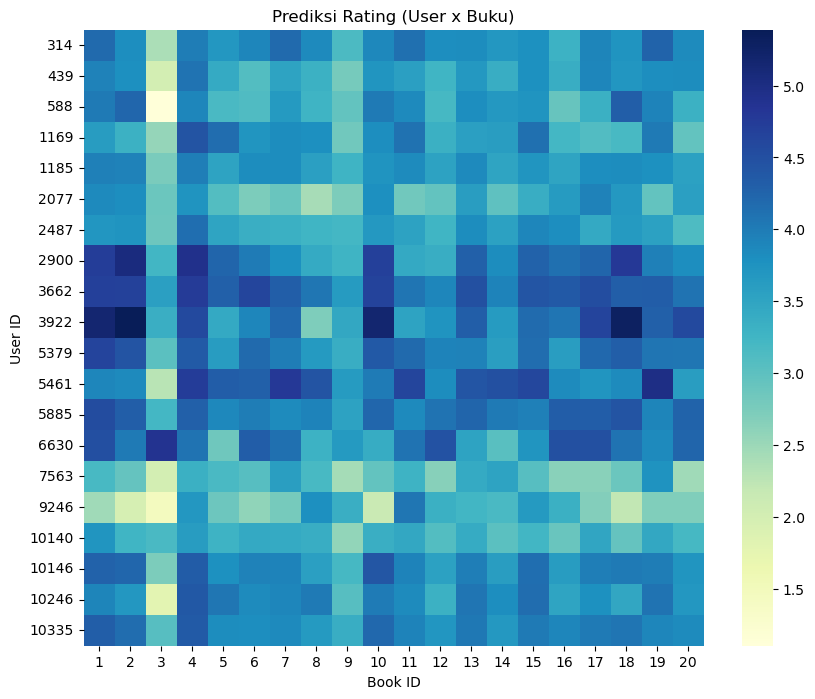

In [137]:
pred_matrix = np.dot(P, Q.T)

# Contoh visualisasi heatmap prediksi 20x20
pred_df = pd.DataFrame(pred_matrix[:20, :20], index=user_ids[:20], columns=book_ids[:20])

plt.figure(figsize=(10, 8))
sns.heatmap(pred_df, cmap='YlGnBu', annot=False)
plt.title('Prediksi Rating (User x Buku)')
plt.xlabel('Book ID')
plt.ylabel('User ID')
plt.show()

In [138]:
threshold = 3.5

y_true = []
y_pred = []

for row in ratings.itertuples():
    u = row.user_index
    i = row.book_index
    true_rating = row.rating
    pred_rating = pred_matrix[u, i]

    # Klasifikasi manual
    true_label = 1 if true_rating >= threshold else 0
    pred_label = 1 if pred_rating >= threshold else 0

    y_true.append(true_label)
    y_pred.append(pred_label)

accuracy = accuracy_score(y_true, y_pred)
print(f"Akurasi klasifikasi berdasarkan threshold {threshold}: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Akurasi klasifikasi berdasarkan threshold 3.5: 86.99%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79      3294
           1       0.88      0.94      0.91      6706

    accuracy                           0.87     10000
   macro avg       0.86      0.83      0.85     10000
weighted avg       0.87      0.87      0.87     10000

